# Forect cover type

We try to predict the type of trees that grow in a 30m x 30m patch based on their conditions.
- Conditions include: elevation, slope, soil-type and amount of sunlight it receives, etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from util import *

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
mpl.rcParams['figure.figsize'] = (12.0, 4.5)

In [4]:
df = pd.read_csv('train.csv', index_col='Id')

In [5]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


## Data exploration
### Elevation, Aspect, Slope

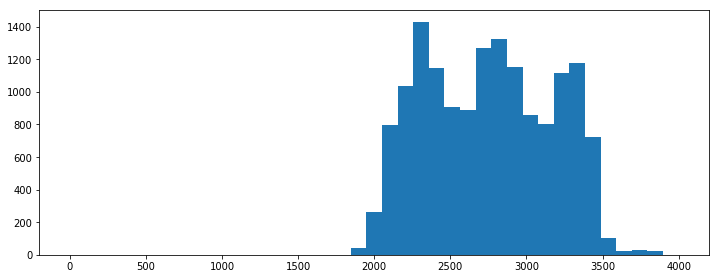

In [6]:
u = plt.hist(df.Elevation, bins=np.linspace(0,4000,40))

In [7]:
# We demean the elevation data
df.Elevation -= df.Elevation.mean()

*The patches are from wilderness area in/near Rocky Mountain National Park. Hence, the relatively high elevation.*

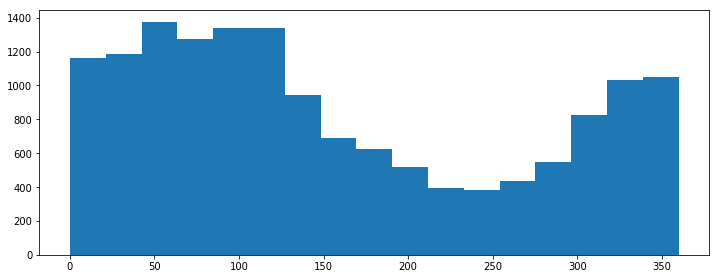

In [8]:
u = plt.hist(df.Aspect, bins=np.linspace(0,360,18))

*Aspect refers to the angle a slope faces relative to the azimuth.*
- 0 degree = North
- 90 degree = East
- 180 degree = South
- 270 degree = West

*Most hills are pointing eastward and not westward.*

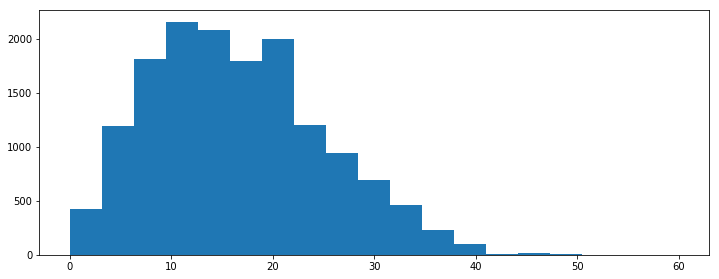

In [9]:
u = plt.hist(df.Slope, np.linspace(0,60,20))

*Mostly the lots are sloped at 10~20 degree.*

### Hillshade

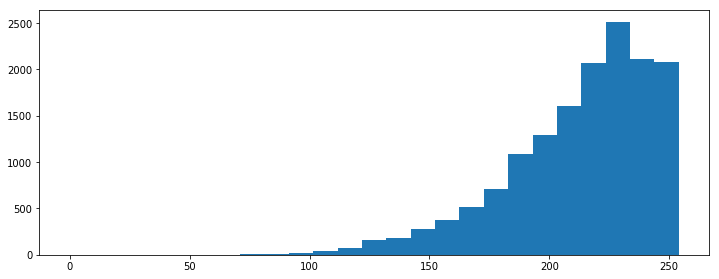

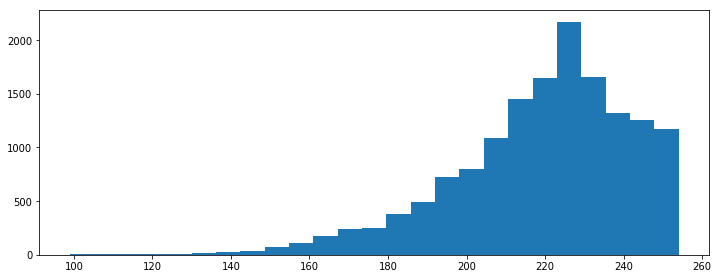

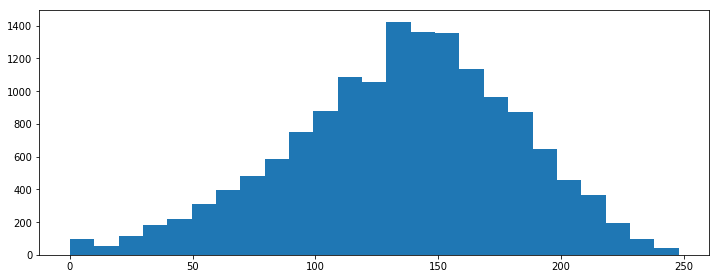

In [10]:
plt.figure()
u = plt.hist(df.Hillshade_9am, bins=25)
plt.figure()
u = plt.hist(df.Hillshade_Noon, bins=25)
plt.figure()
u = plt.hist(df.Hillshade_3pm, bins=25)

 - Results make sense since most of the slopes are facing eastward (more illumination in the morning).
 - This feature may be redundant with the "Aspect" feature.

### Distances to nearest surface water

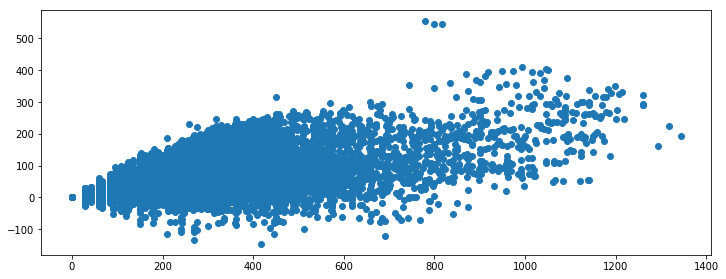

In [11]:
plt.scatter(df.Horizontal_Distance_To_Hydrology, df.Vertical_Distance_To_Hydrology)

- Most of the lots are within 600m of nearest stream/lake.
- Vertically, they are separted by at most ~250m.

### Distance to fire points and roadways

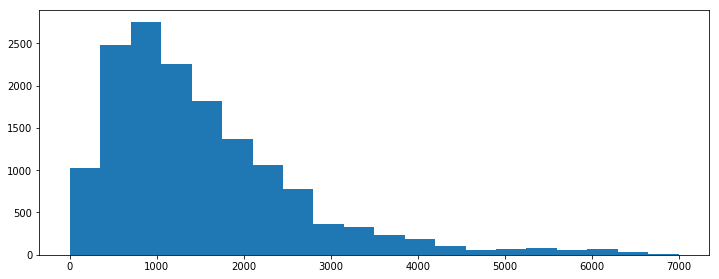

In [12]:
u = plt.hist(df.Horizontal_Distance_To_Fire_Points, bins=20)

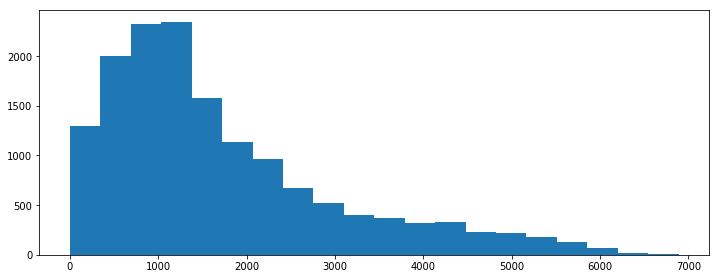

In [13]:
u = plt.hist(df.Horizontal_Distance_To_Roadways, bins=20)

## Feature selection

- Features were chosen based on intuition, before looking at the correlation between the feature and the classification label.
- This maybe counter-intuitive, but we are trying to only use features that have causal relation (i.e., the amount of sunlight in the morning determined the dominant type of tree grown in that lot).

*We note that Lodgepole pine (Pinus Contorta) is a fire dependent species, requiring wildfires to open the cones to release seeds.*

#### The features that are considered:
- Elevation, Aspect, Slope, distances to hydrology, distance to fire, hillshades and soil types.

#### The features that are not considered:
- Distance to roadways, Wilderness area

### Reasons why some features were ignored:
* Distance to roadways shouldn't matter unless seedlings are spread by people/car. Even if there was an effect, the range should be small.
* Wilderness area may help in improving the prediction accuracy but cannot be used as a feature in areas other than the Rockies.



Distance to roadways and fire points could be converted to a categorical variables such as "Within 500m of a roadway/fire point".

## PCA analysis

- We test the numeric features to see if there are correlations between the features
- We hope that the results help us solve the problem by clustering (k-means, etc)

In [14]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [15]:
# The chosen features
var = [
       'Elevation', 
       'Aspect', 
       'Slope', 
       'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Fire_Points',   
       'Hillshade_9am',
       'Hillshade_Noon',
       'Hillshade_3pm'
      ]
X = df[var]

# Names of trees
target_names = ['Spruce/Fur', 
                'Lodgepole pine', 
                'Ponderosa Pine',
                'Cottonwood/Willow',
                'Aspen',
                'Douglas-fir',
                'Krummholz'
               ]
y = df.Cover_Type - 1 # Label starts from 1

In [16]:
# Fit PCA
pca = PCA(n_components=3, whiten=True)
X_r = pca.fit_transform(X)

In [17]:
# Percentage of variance explained for each components
print('explained variance ratio (first few components): %s'
      % str(np.around(pca.explained_variance_ratio_, 3)))
print('\n principal components:')
print(np.around(pca.components_, 2))

explained variance ratio (first few components): [0.863 0.1   0.025]

 principal components:
[[ 0.19 -0.01 -0.    0.04 -0.    0.98  0.    0.    0.  ]
 [-0.94 -0.01  0.   -0.27 -0.04  0.19 -0.   -0.01 -0.01]
 [-0.28  0.04  0.01  0.93  0.22  0.02 -0.02 -0.    0.01]]


- In order of importance, "Distance to Fire point", "Elevation", and "Horizontal distance to water" (orientation of the slope face) is important.
- We also see that the "Horizontal distance to water" has slight correlation with elevation (which makes sense)
- Overall, however, we don't see a huge correlation between variables, hence rendering PCA largely useless.

In [18]:
from sklearn.preprocessing import StandardScaler

var = [
       'Elevation',     
       'Horizontal_Distance_To_Hydrology',
       'Horizontal_Distance_To_Fire_Points',   
      ]
X = df[var].values

scaler = StandardScaler(with_mean=True)
X_r3 = scaler.fit_transform(X)
print(scaler.scale_)
print(scaler.mean_/scaler.scale_)

[ 417.66437501  210.06834865 1099.90011851]
[3.68689623e-16 1.08153228e+00 1.37389501e+00]


## Plot clusters using raw data
- Examine "Elevation", "Horizontal distance to water", and "Distance to Fire point"

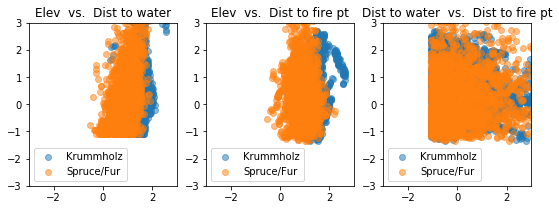

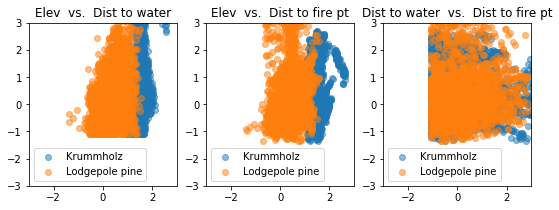

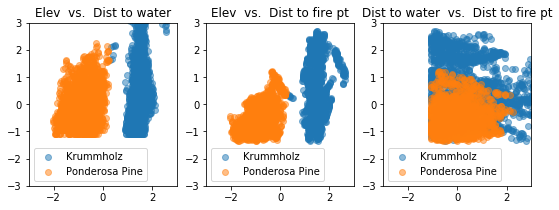

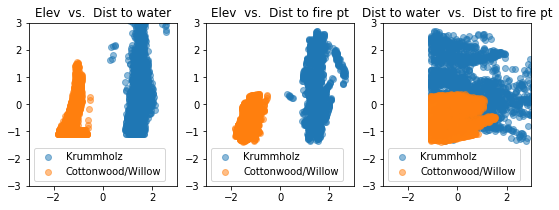

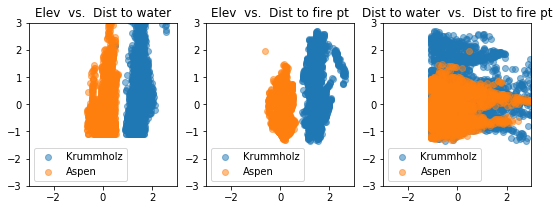

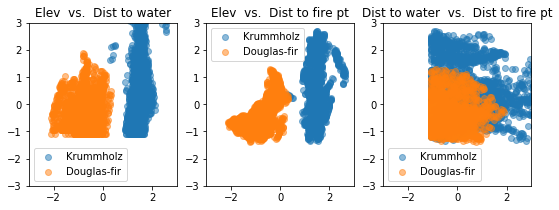

In [19]:
mpl.rcParams['figure.figsize'] = (9.0, 3.0)
label_names = ['Elev', 'Dist to water', 'Dist to fire pt']
label = 6
compareClusters(X_r3, y, label,  target_names, label_names)

### Comments
- Some of the trees can be completely resolved by just considering the elevation.
- Cottonwood and Krummholz occupy lot at a very low/high elevation.



## Linear model

In [20]:
df = df.drop(['Wilderness_Area1', 
              'Wilderness_Area2', 
              'Wilderness_Area3', 
              'Wilderness_Area4', 
              'Cover_Type'], 
            axis=1)
# df = df.drop('Cover_Type', axis=1)

In [21]:
# Rescale only numeric features
for col in df.columns:
    if 'Hillshade' in col:
        df[col] = df[col]/255
    elif 'Soil' not in col:
        df[col] = df[col]/df[col].std()


In [22]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.367083,0.463275,0.354865,1.228131,0.000000,0.384886,0.866667,0.909804,0.580392,5.708511,...,0,0,0,0,0,0,0,0,0,0
2,-0.381448,0.508694,0.236576,1.009162,-0.097976,0.294325,0.862745,0.921569,0.592157,5.659418,...,0,0,0,0,0,0,0,0,0,0
3,0.130908,1.262651,1.064594,1.275733,1.061408,2.399880,0.917647,0.933333,0.529412,5.564867,...,0,0,0,0,0,0,0,0,0,0
4,0.085419,1.407993,2.129188,1.151968,1.926864,2.331959,0.933333,0.933333,0.478431,5.646690,...,0,0,0,0,0,0,0,0,0,0
5,-0.369477,0.408772,0.236576,0.728310,-0.016329,0.295080,0.862745,0.917647,0.588235,5.611233,...,0,0,0,0,0,0,0,0,0,0


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
clf = LogisticRegression(C=0.1, multi_class='multinomial', solver='saga', penalty='l1')
clf.fit(X_train, y_train)

/home/jun/Dropbox/CS/.env/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
score = clf.score(X_test, y_test)
print("Test score with L2 penalty: %.4f" % score)

Test score with L2 penalty: 0.6806


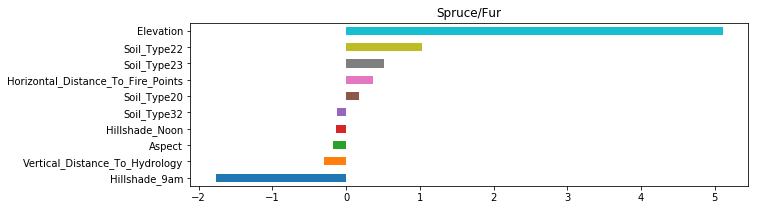

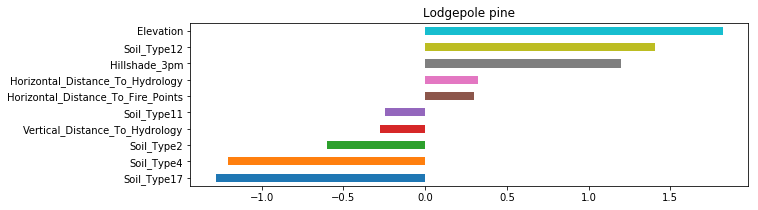

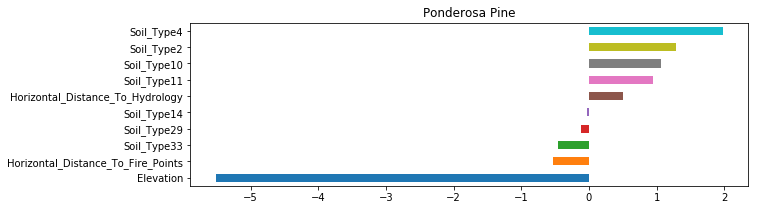

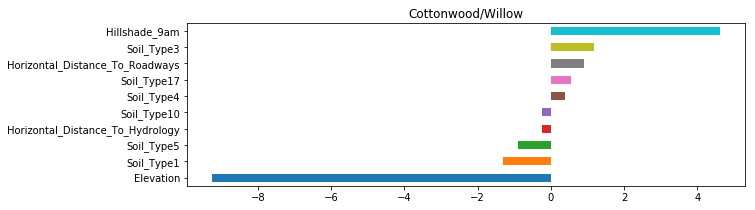

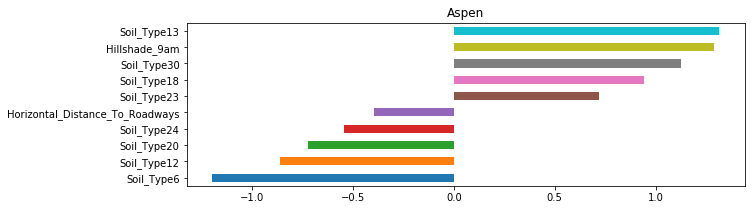

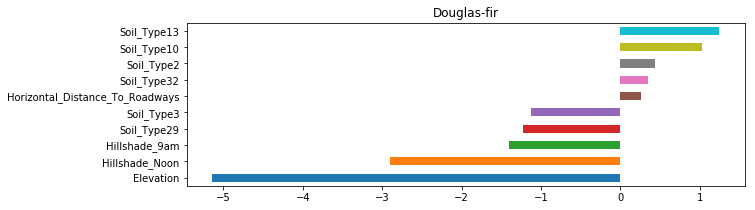

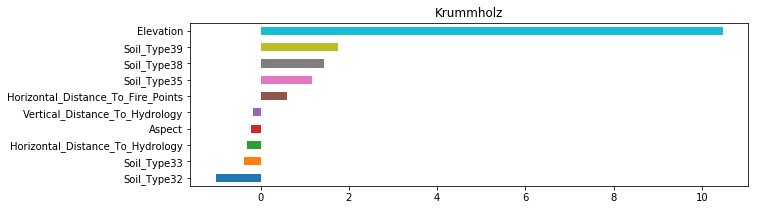

In [26]:
mpl.rcParams['figure.figsize'] = (10.0, 3.0)

num_categories = len(clf.coef_)
for i in range(num_categories):
    coef = pd.Series(clf.coef_[i], index=df.columns)
    num_coef = 5

    imp_coef = pd.concat([coef.sort_values().head(num_coef),
                          coef.sort_values().tail(num_coef)])

    plt.figure()
    imp_coef.plot(kind='barh')
    plt.title(target_names[i])


### Notes on tree species
- _Spruce/Fir_: vulnerable to fire due to thin skin, need deep soil, not rocky (**fire dist, soil condition, slope**)

- _Lodgepole pine_: require wildfire to spread the seed (**fire dist**)

- _Ponderosa Pine_: no distinct feature

- _Cottonwood/Willow_: low altitude, live by the water (**elevation**)

- _Aspen_: Roots survive forest fire, does not like shade (**fire dist, hillshade**)

- _Douglas-fir_: prefers acidic or neutral soil, can survive fire due to thick bark (**soil-type, fire dist**)

- _Krummholz_: stunted windblown, grows near the tree lines (**elevation**)


### Note on soil type
- _Spruce/Fir_ grows in Leighcan soil (soil 22/23) because they are deep (~60 inch)

(https://soilseries.sc.egov.usda.gov/OSD_Docs/L/LEIGHCAN.html)

- _Douglas-fir_ grows in Catamount soil (soil 10/13) because they are strongly acidic (pH 5.3)

(https://soilseries.sc.egov.usda.gov/OSD_Docs/C/CATAMOUNT.html)


## Plot confusion matrix
- To evaluate which categories we are doing badly in, we plot the confusion matrix

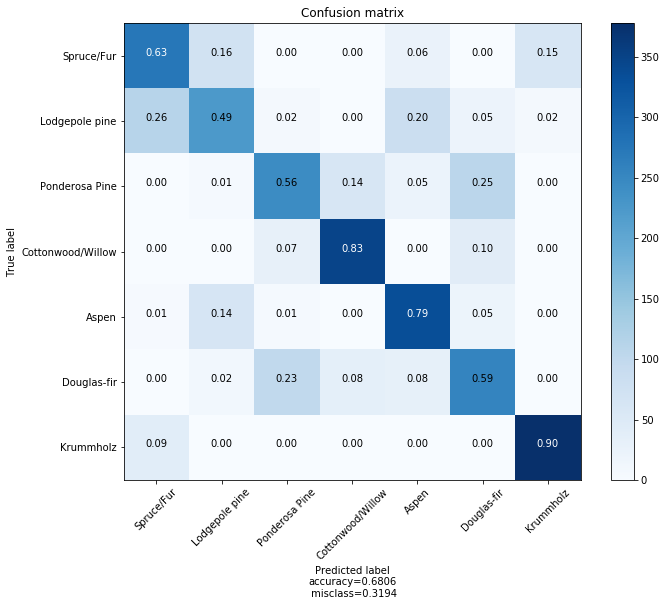

In [27]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
plot_confusion_matrix(cm, normalize=True, target_names=target_names)

### Comments
- Trees that can be separated via "elevation" are easily distinguished from other species.

## Use Xgboost

In [28]:
from xgboost import XGBClassifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=7, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


/home/jun/Dropbox/CS/.env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


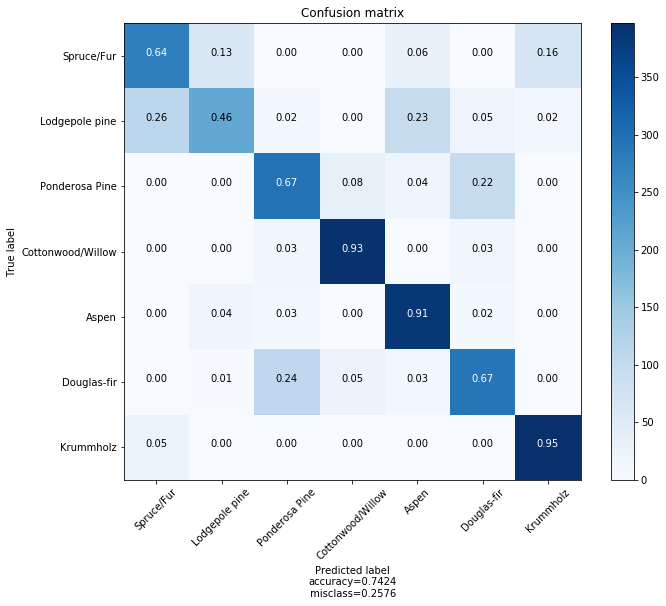

In [29]:
model = XGBClassifier(n_jobs=7)
model.fit(X_train, y_train)
print(model)

# Compare the confusion matrix
y_pred_xgb = model.predict(X_test)
cm_xgb = confusion_matrix(y_pred=y_pred_xgb, y_true=y_test)
plot_confusion_matrix(cm_xgb, normalize=True, target_names=target_names)

#### Comments
- With no tuning, xgboost significantly improves the Cottonwood and Aspen results.

/home/jun/Dropbox/CS/.env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


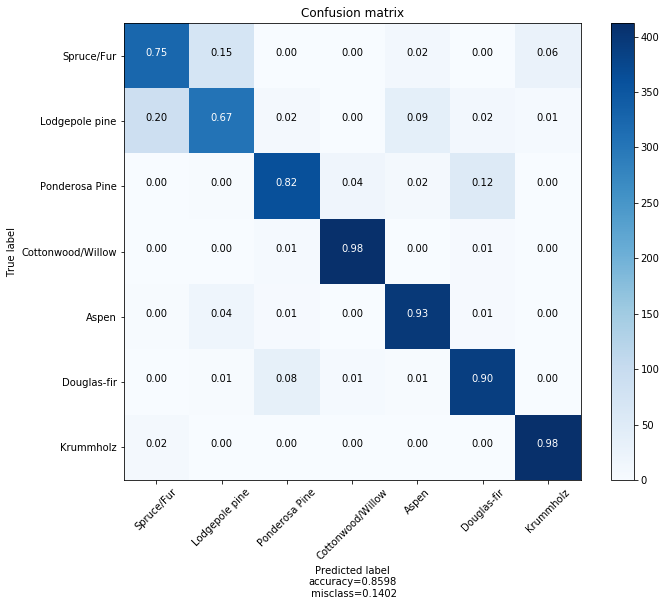

In [30]:
model = XGBClassifier(n_jobs=7, max_depth=6, learning_rate=0.5, reg_lambda=0.2)
model.fit(X_train, y_train)

# Compare the confusion matrix
y_pred_xgb = model.predict(X_test)
cm_xgb = confusion_matrix(y_pred=y_pred_xgb, y_true=y_test)
plot_confusion_matrix(cm_xgb, normalize=True, target_names=target_names)

#### Comments
- By tweaking the max_depth and learning rate (it controls the importance of new functions), we can raise the prediction accuracy to a certain level

# Final words
- Scatterplots showed that elevation is the main discriminator
- The coefficients from logistic regression confirmed the importance of the elevation
- Soil types and hillshades were also important

Scatterplots and logistic regressions, even though they are limited use in finding a good predictive model, nonetheless is helpful in gaining insight into the underlying structure of the data and what we are trying to understand.